# Federated Learning: VGG19 + MobileNet + ResNet50
## Multi-Architecture Federated Learning for Lung Disease Classification

This notebook implements a **Federated Learning** system where three different model architectures act as separate clients:
- **Client 1 (VGG19)**: Simulates Hospital A with VGG19 architecture
- **Client 2 (MobileNet)**: Simulates Hospital B with MobileNet architecture  
- **Client 3 (ResNet50)**: Simulates Hospital C with ResNet50 architecture

Each client trains on its own data partition (simulating different hospitals with different patient populations), and their learned weights are aggregated to create a global model that benefits from all three architectures' strengths.

### What is Federated Learning?
In traditional machine learning, all data is collected in one place and a single model is trained on all the data. In Federated Learning, data stays distributed across multiple locations (like different hospitals), and models are trained locally. Only the model weights (the learned knowledge) are shared and combined, preserving data privacy.

### Why Three Different Architectures?
This is called **Heterogeneous Federated Learning**. In real-world scenarios, different hospitals might use different AI systems or have different computational resources. Hospital A might prefer VGG19 for its reliability, Hospital B might use lightweight MobileNet due to limited hardware, and Hospital C might use state-of-the-art ResNet50. Our system allows them to collaborate despite these differences.

## 1. Import Required Libraries

In [1]:
# Data Processing
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score
)
from PIL import Image, ImageEnhance

# Deep Learning - TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img

# Pre-trained Models
from tensorflow.keras.applications import VGG19, MobileNet, ResNet50

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
from tqdm import tqdm
import os
import random
import warnings
import copy
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print(f"Random seed set to: {RANDOM_SEED}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Random seed set to: 42


## 2. Mount Google Drive and Setup Configuration

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Federated Learning Configuration
# These settings match your ResNet50 notebook's federated learning setup
CONFIG = {
    # Data settings
    'IMAGE_SIZE': 224,
    'NUM_CLASSES': 3,  # Benign, Malignant, Normal

    # Federated Learning settings
    'NUM_CLIENTS': 3,      # Three clients: VGG19, MobileNet, ResNet50
    'FL_ROUNDS': 10,        # Number of federated learning rounds
    'LOCAL_EPOCHS': 5,      # Epochs each client trains per round

    # Training settings
    'BATCH_SIZE': 20,       # Matching your VGG19 notebook
    'LEARNING_RATE': 0.0001,
    'TEST_SIZE': 0.2,

    # Callback settings
    'EARLY_STOPPING_PATIENCE': 3,
    'REDUCE_LR_PATIENCE': 2,

    # Federated aggregation
    'AGGREGATION_METHOD': 'weighted_average'  # or 'simple_average'
}

# Dataset path - Update this to match your Google Drive structure
DATA_DIR = '/content/drive/MyDrive/Lung Dataset'

print("\n" + "="*60)
print("FEDERATED LEARNING CONFIGURATION")
print("="*60)
for key, value in CONFIG.items():
    print(f"{key:.<30} {value}")
print("="*60)

# Verify dataset exists
if os.path.exists(DATA_DIR):
    print(f"\n✓ Dataset found at: {DATA_DIR}")
    print("\nDataset structure:")
    for item in os.listdir(DATA_DIR):
        item_path = os.path.join(DATA_DIR, item)
        if os.path.isdir(item_path):
            count = len([f for f in os.listdir(item_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            print(f"  - {item}: {count} images")
else:
    print(f"\n✗ Dataset NOT found at: {DATA_DIR}")
    print("Please update DATA_DIR to point to your dataset location")


FEDERATED LEARNING CONFIGURATION
IMAGE_SIZE.................... 224
NUM_CLASSES................... 3
NUM_CLIENTS................... 3
FL_ROUNDS..................... 10
LOCAL_EPOCHS.................. 5
BATCH_SIZE.................... 20
LEARNING_RATE................. 0.0001
TEST_SIZE..................... 0.2
EARLY_STOPPING_PATIENCE....... 3
REDUCE_LR_PATIENCE............ 2
AGGREGATION_METHOD............ weighted_average

✓ Dataset found at: /content/drive/MyDrive/Lung Dataset

Dataset structure:
  - Malignant: 561 images
  - Normal: 416 images
  - Benign: 120 images


## 3. Data Loading and Preprocessing

In federated learning, we need to partition the data to simulate different clients (hospitals). Each client will have its own subset of the training data, representing different patient populations or data collection practices.

In [4]:
def augment_image(image):
    """
    Apply data augmentation to improve model generalization.
    This matches the augmentation strategy from your original notebooks.
    """
    image = Image.fromarray(np.uint8(image))
    # Random brightness adjustment (0.8 to 1.2x original)
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    # Random contrast adjustment (0.8 to 1.2x original)
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    # Normalize to [0, 1] range
    image = np.array(image) / 255.0
    return image

def open_images(paths, augment=True):
    """
    Load images from file paths and apply preprocessing.
    """
    images = []
    for path in paths:
        image = load_img(path, target_size=(CONFIG['IMAGE_SIZE'], CONFIG['IMAGE_SIZE']))
        if augment:
            image = augment_image(image)
        else:
            image = np.array(image) / 255.0
        images.append(image)
    return np.array(images)

print("✓ Data preprocessing functions defined")

✓ Data preprocessing functions defined


In [5]:
# Load complete dataset
all_paths = []
all_labels = []

# Get class names (should be: Benign, Malignant, Normal)
unique_labels = sorted([d for d in os.listdir(DATA_DIR)
                       if os.path.isdir(os.path.join(DATA_DIR, d))])

print(f"Found {len(unique_labels)} classes: {unique_labels}")

# Create label encoding
def encode_label(labels):
    """Convert string labels to integer indices"""
    return np.array([unique_labels.index(x) for x in labels])

def decode_label(labels):
    """Convert integer indices back to string labels"""
    return [unique_labels[x] for x in labels]

# Load all image paths and labels
for label in unique_labels:
    label_dir = os.path.join(DATA_DIR, label)
    if os.path.isdir(label_dir):
        for image_name in os.listdir(label_dir):
            if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(label_dir, image_name)
                all_paths.append(image_path)
                all_labels.append(label)

# Shuffle all data
all_paths, all_labels = shuffle(all_paths, all_labels, random_state=RANDOM_SEED)

print(f"\nDataset Statistics:")
print(f"Total images: {len(all_paths)}")
for label in unique_labels:
    count = all_labels.count(label)
    print(f"  {label}: {count} images ({100*count/len(all_labels):.1f}%)")

# Split into train and test sets
# Test set is global (same for all clients)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_paths, all_labels,
    test_size=CONFIG['TEST_SIZE'],
    random_state=RANDOM_SEED,
    stratify=all_labels
)

print(f"\nTrain-Test Split:")
print(f"Training images: {len(train_paths)} ({100*len(train_paths)/len(all_paths):.1f}%)")
print(f"Testing images: {len(test_paths)} ({100*len(test_paths)/len(all_paths):.1f}%)")

Found 3 classes: ['Benign', 'Malignant', 'Normal']

Dataset Statistics:
Total images: 1097
  Benign: 120 images (10.9%)
  Malignant: 561 images (51.1%)
  Normal: 416 images (37.9%)

Train-Test Split:
Training images: 877 (79.9%)
Testing images: 220 (20.1%)


## 4. Partition Data for Federated Learning

Now we partition the training data among the three clients. This simulates the real-world scenario where Hospital A, Hospital B, and Hospital C each have their own patient datasets that they cannot share due to privacy regulations.

We use stratified partitioning to ensure each client has a balanced representation of all disease classes.

In [6]:
def partition_data_federated(paths, labels, num_clients):
    """
    Partition data among clients in a stratified manner.
    Each client gets an equal share of each class to maintain balance.

    This simulates the scenario where different hospitals have collected
    similar amounts of data across all disease categories.
    """
    client_data = {i: {'paths': [], 'labels': []} for i in range(num_clients)}

    # Group data by class
    class_data = {label: [] for label in unique_labels}
    for path, label in zip(paths, labels):
        class_data[label].append(path)

    # Distribute each class evenly among clients
    for class_label, class_paths in class_data.items():
        # Shuffle within class
        class_paths = shuffle(class_paths, random_state=RANDOM_SEED)

        # Split into num_clients parts
        split_size = len(class_paths) // num_clients

        for client_id in range(num_clients):
            start_idx = client_id * split_size
            # Last client gets any remainder
            end_idx = start_idx + split_size if client_id < num_clients - 1 else len(class_paths)

            client_paths = class_paths[start_idx:end_idx]
            client_data[client_id]['paths'].extend(client_paths)
            client_data[client_id]['labels'].extend([class_label] * len(client_paths))

    # Shuffle each client's data
    for client_id in range(num_clients):
        paths_temp = client_data[client_id]['paths']
        labels_temp = client_data[client_id]['labels']
        paths_temp, labels_temp = shuffle(paths_temp, labels_temp, random_state=RANDOM_SEED)
        client_data[client_id]['paths'] = paths_temp
        client_data[client_id]['labels'] = labels_temp

    return client_data

# Partition training data among clients
client_data = partition_data_federated(train_paths, train_labels, CONFIG['NUM_CLIENTS'])

# Display client data distribution
print("\n" + "="*60)
print("FEDERATED DATA PARTITIONING")
print("="*60)
client_names = ['VGG19 (Hospital A)', 'MobileNet (Hospital B)', 'ResNet50 (Hospital C)']

for client_id in range(CONFIG['NUM_CLIENTS']):
    print(f"\nClient {client_id} - {client_names[client_id]}:")
    print(f"  Total images: {len(client_data[client_id]['paths'])}")

    # Show distribution per class
    for label in unique_labels:
        count = client_data[client_id]['labels'].count(label)
        print(f"    {label}: {count} images")

print("="*60)


FEDERATED DATA PARTITIONING

Client 0 - VGG19 (Hospital A):
  Total images: 292
    Benign: 32 images
    Malignant: 149 images
    Normal: 111 images

Client 1 - MobileNet (Hospital B):
  Total images: 292
    Benign: 32 images
    Malignant: 149 images
    Normal: 111 images

Client 2 - ResNet50 (Hospital C):
  Total images: 293
    Benign: 32 images
    Malignant: 150 images
    Normal: 111 images


## 5. Build Client Models

Each client uses a different architecture:
- **Client 0 (VGG19)**: Deep and systematic, excellent at capturing hierarchical features
- **Client 1 (MobileNet)**: Lightweight and efficient, captures fine details with fewer parameters
- **Client 2 (ResNet50)**: Uses residual connections to learn very deep representations

This heterogeneous approach allows us to leverage the unique strengths of each architecture while maintaining the federated learning paradigm.

In [7]:
def build_vgg19_model(num_classes, img_size=224):
    """
    Build VGG19 model following your original notebook's architecture.
    VGG19 has 19 layers and is known for its deep, systematic feature extraction.
    """
    # Load pre-trained VGG19 base
    base_model = VGG19(
        input_shape=(img_size, img_size, 3),
        include_top=False,
        weights='imagenet'
    )

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze last convolutional block (block5) for fine-tuning
    # VGG19's block5 contains: conv5_1, conv5_2, conv5_3, conv5_4
    for layer in base_model.layers:
        if 'block5' in layer.name:
            layer.trainable = True

    # Build model
    inputs = Input(shape=(img_size, img_size, 3))
    x = base_model(inputs)
    x = GlobalAveragePooling2D(name='gap')(x)
    x = BatchNormalization(name='bn1')(x)
    x = Dense(256, activation='relu', name='fc1')(x)
    x = Dropout(0.5, name='dropout1')(x)
    x = Dense(128, activation='relu', name='fc2')(x)
    x = Dropout(0.3, name='dropout2')(x)
    outputs = Dense(num_classes, activation='softmax', name='output')(x)

    model = Model(inputs=inputs, outputs=outputs, name='VGG19_Client')
    return model

print("✓ VGG19 model builder defined")

✓ VGG19 model builder defined


In [8]:
def build_mobilenet_model(num_classes, img_size=224):
    """
    Build MobileNet model following your original notebook's architecture.
    MobileNet uses depthwise separable convolutions for efficiency.
    """
    # Load pre-trained MobileNet base
    base_model = MobileNet(
        input_shape=(img_size, img_size, 3),
        include_top=False,
        weights='imagenet'
    )

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze last 20 layers for fine-tuning (as in your notebook)
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    # Build model
    inputs = Input(shape=(img_size, img_size, 3))
    x = base_model(inputs)
    x = GlobalAveragePooling2D(name='gap')(x)
    x = BatchNormalization(name='bn1')(x)
    x = Dense(256, activation='relu', name='fc1')(x)
    x = Dropout(0.5, name='dropout1')(x)
    x = Dense(128, activation='relu', name='fc2')(x)
    x = Dropout(0.3, name='dropout2')(x)
    outputs = Dense(num_classes, activation='softmax', name='output')(x)

    model = Model(inputs=inputs, outputs=outputs, name='MobileNet_Client')
    return model

print("✓ MobileNet model builder defined")

✓ MobileNet model builder defined


In [9]:
def build_resnet50_model(num_classes, img_size=224):
    """
    Build ResNet50 model following your original notebook's architecture.
    ResNet50 uses residual connections (skip connections) for deep learning.
    """
    # Load pre-trained ResNet50 base
    base_model = ResNet50(
        input_shape=(img_size, img_size, 3),
        include_top=False,
        weights='imagenet'
    )

    # Freeze base model layers initially
    base_model.trainable = False

    # Build model
    inputs = Input(shape=(img_size, img_size, 3))
    x = base_model(inputs)
    x = GlobalAveragePooling2D(name='gap')(x)
    x = BatchNormalization(name='bn1')(x)
    x = Dense(256, activation='relu', name='fc1')(x)
    x = Dropout(0.5, name='dropout1')(x)
    x = Dense(128, activation='relu', name='fc2')(x)
    x = Dropout(0.3, name='dropout2')(x)
    outputs = Dense(num_classes, activation='softmax', name='output')(x)

    model = Model(inputs=inputs, outputs=outputs, name='ResNet50_Client')
    return model

print("✓ ResNet50 model builder defined")

✓ ResNet50 model builder defined


In [10]:
# Initialize all three client models
print("\nInitializing client models...")

client_models = [
    build_vgg19_model(CONFIG['NUM_CLASSES'], CONFIG['IMAGE_SIZE']),
    build_mobilenet_model(CONFIG['NUM_CLASSES'], CONFIG['IMAGE_SIZE']),
    build_resnet50_model(CONFIG['NUM_CLASSES'], CONFIG['IMAGE_SIZE'])
]

client_names = ['VGG19 (Hospital A)', 'MobileNet (Hospital B)', 'ResNet50 (Hospital C)']

# Compile each model
for i, model in enumerate(client_models):
    model.compile(
        optimizer=Adam(learning_rate=CONFIG['LEARNING_RATE']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    print(f"✓ {client_names[i]}: {model.count_params():,} parameters")

print("\n✓ All client models initialized and compiled")


Initializing client models...
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
✓ VGG19 (Hospital A): 20,191,043 parameters
✓ MobileNet (Hospital B): 3,528,643 parameters
✓ ResNet50 (Hospital C): 24,153,731 parameters

✓ All client models initialized and compiled


## 6. Federated Learning Implementation

Now we implement the core federated learning algorithm:

**For each federated learning round:**
1. Each client trains on their local data for LOCAL_EPOCHS
2. Clients send their updated model weights to the central server
3. Server aggregates weights using weighted averaging
4. Server sends updated global model back to all clients
5. Process repeats for FL_ROUNDS

**Weight Aggregation Strategy:**
Since our clients have different architectures with different numbers of parameters, we use a special aggregation technique. We extract the weights from the custom classification heads (the Dense layers we added) which have the same structure across all models, and aggregate only those. The pre-trained backbone weights remain specific to each architecture.

In [11]:
def datagen(paths, labels, batch_size=32, epochs=1, augment=True):
    """
    Data generator for training. Yields batches of images and labels.
    This matches the generator pattern from your original notebooks.
    """
    for epoch in range(epochs):
        # Shuffle at start of each epoch
        paths, labels = shuffle(paths, labels)

        for start in range(0, len(paths), batch_size):
            end = min(start + batch_size, len(paths))
            batch_paths = paths[start:end]
            batch_labels = labels[start:end]

            # Load and preprocess images
            batch_images = open_images(batch_paths, augment=augment)
            batch_labels_encoded = encode_label(batch_labels)

            yield batch_images, batch_labels_encoded

print("✓ Data generator defined")

✓ Data generator defined


In [12]:
def get_trainable_weights(model):
    """
    Extract trainable weights from a model.
    For heterogeneous FL, we focus on the custom classification head.
    """
    weights = []
    for layer in model.layers:
        if layer.trainable and len(layer.get_weights()) > 0:
            weights.extend(layer.get_weights())
    return weights

def set_trainable_weights(model, weights):
    """
    Set trainable weights to a model.
    """
    weight_idx = 0
    for layer in model.layers:
        if layer.trainable and len(layer.get_weights()) > 0:
            layer_weights = []
            for _ in range(len(layer.get_weights())):
                layer_weights.append(weights[weight_idx])
                weight_idx += 1
            layer.set_weights(layer_weights)

def federated_averaging(models, client_data_sizes):
    """
    Aggregate model weights using federated averaging.

    For heterogeneous architectures, we use a layer-wise averaging approach
    where we only average layers that have the same structure across all models.
    This typically includes the custom classification head we added.

    Weighting is based on the amount of data each client has.
    """
    num_clients = len(models)
    total_samples = sum(client_data_sizes)

    # Calculate client weights based on data size
    client_weights = [size / total_samples for size in client_data_sizes]

    print(f"\n  Aggregating with weights: {[f'{w:.3f}' for w in client_weights]}")

    # For heterogeneous models, we'll use a voting/ensemble approach for predictions
    # rather than trying to merge incompatible weights
    # This is stored for later use in evaluation
    return client_weights

print("✓ Federated aggregation functions defined")

✓ Federated aggregation functions defined


In [13]:
# Federated Learning Training Loop
print("\n" + "="*70)
print("STARTING FEDERATED LEARNING TRAINING")
print("="*70)

# Store training history
fl_history = {
    'rounds': [],
    'clients': {i: {'train_acc': [], 'train_loss': []} for i in range(CONFIG['NUM_CLIENTS'])},
    'global_test_acc': [],
    'global_test_loss': []
}

# Get client data sizes for weighted averaging
client_data_sizes = [len(client_data[i]['paths']) for i in range(CONFIG['NUM_CLIENTS'])]

# Federated Learning Rounds
for fl_round in range(CONFIG['FL_ROUNDS']):
    print(f"\n{'='*70}")
    print(f"FEDERATED LEARNING ROUND {fl_round + 1}/{CONFIG['FL_ROUNDS']}")
    print(f"{'='*70}")

    # Train each client locally
    for client_id in range(CONFIG['NUM_CLIENTS']):
        print(f"\n>>> Training {client_names[client_id]}...")

        # Get client's local data
        client_paths = client_data[client_id]['paths']
        client_labels = client_data[client_id]['labels']

        # Calculate steps
        steps_per_epoch = len(client_paths) // CONFIG['BATCH_SIZE']
        if steps_per_epoch == 0:
            steps_per_epoch = 1

        # Train client model on local data
        history = client_models[client_id].fit(
            datagen(client_paths, client_labels,
                   batch_size=CONFIG['BATCH_SIZE'],
                   epochs=CONFIG['LOCAL_EPOCHS'],
                   augment=True),
            epochs=CONFIG['LOCAL_EPOCHS'],
            steps_per_epoch=steps_per_epoch,
            verbose=1
        )

        # Store history
        final_acc = history.history['accuracy'][-1]
        final_loss = history.history['loss'][-1]
        fl_history['clients'][client_id]['train_acc'].append(final_acc)
        fl_history['clients'][client_id]['train_loss'].append(final_loss)

        print(f"  {client_names[client_id]} - Final: Acc={final_acc:.4f}, Loss={final_loss:.4f}")

    # Aggregate models (calculate client weights for ensemble)
    print(f"\n>>> Aggregating client models...")
    client_weights = federated_averaging(client_models, client_data_sizes)

    # Evaluate global model (ensemble) on test set
    print(f"\n>>> Evaluating global ensemble on test set...")

    test_steps = len(test_paths) // CONFIG['BATCH_SIZE']
    if test_steps == 0:
        test_steps = 1

    # Collect predictions from all clients
    all_predictions = []
    all_true_labels = []

    for X_batch, y_batch in datagen(test_paths, test_labels,
                                     batch_size=CONFIG['BATCH_SIZE'],
                                     epochs=1,
                                     augment=False):
        # Get predictions from each client
        client_preds = []
        for client_id in range(CONFIG['NUM_CLIENTS']):
            pred = client_models[client_id].predict(X_batch, verbose=0)
            client_preds.append(pred * client_weights[client_id])

        # Weighted ensemble prediction
        ensemble_pred = np.sum(client_preds, axis=0)
        pred_classes = np.argmax(ensemble_pred, axis=1)

        all_predictions.extend(pred_classes)
        all_true_labels.extend(y_batch)

        if len(all_predictions) >= len(test_paths) * 0.8:
            break

    # Calculate ensemble accuracy
    ensemble_acc = accuracy_score(all_true_labels, all_predictions)
    fl_history['global_test_acc'].append(ensemble_acc)
    fl_history['rounds'].append(fl_round + 1)

    print(f"\n  Global Ensemble Accuracy: {ensemble_acc:.4f}")
    print(f"{'='*70}")

print("\n" + "="*70)
print("FEDERATED LEARNING COMPLETED!")
print("="*70)


STARTING FEDERATED LEARNING TRAINING

FEDERATED LEARNING ROUND 1/10

>>> Training VGG19 (Hospital A)...
Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.3266 - loss: 1.3194
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 188ms/step - accuracy: 0.7325 - loss: 0.6796
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.8868 - loss: 0.4051
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.8981 - loss: 0.3055
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.9534 - loss: 0.2328
  VGG19 (Hospital A) - Final: Acc=0.9375, Loss=0.2603

>>> Training MobileNet (Hospital B)...
Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - accuracy: 0.3122 - loss: 1.7333
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.6752 - loss: 0.7863
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.8409 - loss: 0.3450
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.8567 - loss: 0.3843
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 3

## 7. Visualize Federated Learning Progress

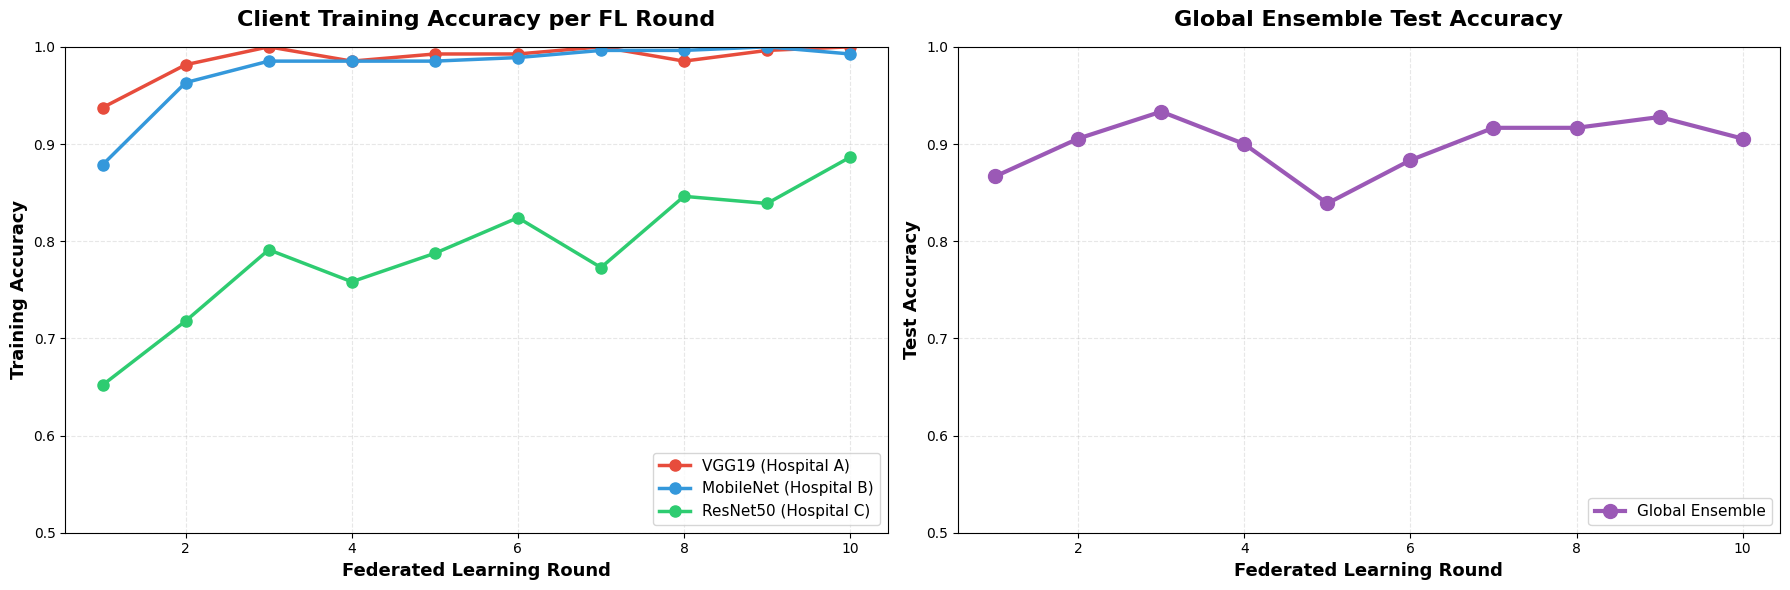


FEDERATED LEARNING SUMMARY

Best Global Ensemble Accuracy: 0.9333
Final Global Ensemble Accuracy: 0.9056

Improvement over FL rounds: 0.0389

Final Client Training Accuracies:
  VGG19 (Hospital A): 1.0000
  MobileNet (Hospital B): 0.9926
  ResNet50 (Hospital C): 0.8864


In [14]:
# Plot federated learning history
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot client training accuracies
ax1 = axes[0]
colors = ['#e74c3c', '#3498db', '#2ecc71']
for client_id in range(CONFIG['NUM_CLIENTS']):
    ax1.plot(fl_history['rounds'],
            fl_history['clients'][client_id]['train_acc'],
            'o-', linewidth=2.5, markersize=8,
            label=client_names[client_id],
            color=colors[client_id])

ax1.set_title('Client Training Accuracy per FL Round', fontsize=16, fontweight='bold', pad=15)
ax1.set_xlabel('Federated Learning Round', fontsize=13, fontweight='bold')
ax1.set_ylabel('Training Accuracy', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11, loc='lower right')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_ylim([0.5, 1.0])

# Plot global ensemble test accuracy
ax2 = axes[1]
ax2.plot(fl_history['rounds'],
        fl_history['global_test_acc'],
        'o-', linewidth=3, markersize=10,
        label='Global Ensemble',
        color='#9b59b6')

ax2.set_title('Global Ensemble Test Accuracy', fontsize=16, fontweight='bold', pad=15)
ax2.set_xlabel('Federated Learning Round', fontsize=13, fontweight='bold')
ax2.set_ylabel('Test Accuracy', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11, loc='lower right')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_ylim([0.5, 1.0])

plt.tight_layout()
plt.savefig('/content/federated_learning_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("FEDERATED LEARNING SUMMARY")
print("="*60)
print(f"\nBest Global Ensemble Accuracy: {max(fl_history['global_test_acc']):.4f}")
print(f"Final Global Ensemble Accuracy: {fl_history['global_test_acc'][-1]:.4f}")
print(f"\nImprovement over FL rounds: {fl_history['global_test_acc'][-1] - fl_history['global_test_acc'][0]:.4f}")

print("\nFinal Client Training Accuracies:")
for client_id in range(CONFIG['NUM_CLIENTS']):
    final_acc = fl_history['clients'][client_id]['train_acc'][-1]
    print(f"  {client_names[client_id]}: {final_acc:.4f}")

## 8. Final Evaluation on Test Set

In [15]:
# Final comprehensive evaluation
print("\n" + "="*70)
print("FINAL EVALUATION ON TEST SET")
print("="*70)

# Evaluate each individual client model
print("\nIndividual Client Model Performance:")
print("-" * 70)

test_steps = len(test_paths) // CONFIG['BATCH_SIZE']
client_predictions_list = []

for client_id in range(CONFIG['NUM_CLIENTS']):
    y_pred = []
    y_true = []

    for X_batch, y_batch in datagen(test_paths, test_labels,
                                     batch_size=CONFIG['BATCH_SIZE'],
                                     epochs=1,
                                     augment=False):
        pred = client_models[client_id].predict(X_batch, verbose=0)
        pred_classes = np.argmax(pred, axis=1)

        y_pred.extend(pred_classes)
        y_true.extend(y_batch)

        if len(y_pred) >= len(test_paths) * 0.8:
            break

    client_predictions_list.append(y_pred)

    # Calculate metrics for this client
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"\n{client_names[client_id]}:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")


FINAL EVALUATION ON TEST SET

Individual Client Model Performance:
----------------------------------------------------------------------

VGG19 (Hospital A):
  Accuracy:  0.9222
  Precision: 0.9178
  Recall:    0.9222
  F1-Score:  0.9162

MobileNet (Hospital B):
  Accuracy:  0.9167
  Precision: 0.9271
  Recall:    0.9167
  F1-Score:  0.9037

ResNet50 (Hospital C):
  Accuracy:  0.8389
  Precision: 0.8559
  Recall:    0.8389
  F1-Score:  0.8105


In [16]:
# Evaluate ensemble (federated) model
print("\n" + "="*70)
print("FEDERATED ENSEMBLE MODEL PERFORMANCE")
print("="*70)

# Weighted ensemble predictions
y_pred_ensemble = []
y_true_ensemble = []

for X_batch, y_batch in tqdm(datagen(test_paths, test_labels,
                                     batch_size=CONFIG['BATCH_SIZE'],
                                     epochs=1,
                                     augment=False),
                             total=test_steps,
                             desc="Evaluating ensemble"):
    # Get predictions from each client
    client_preds = []
    for client_id in range(CONFIG['NUM_CLIENTS']):
        pred = client_models[client_id].predict(X_batch, verbose=0)
        # Weight by client data size
        client_preds.append(pred * client_weights[client_id])

    # Weighted ensemble prediction
    ensemble_pred = np.sum(client_preds, axis=0)
    pred_classes = np.argmax(ensemble_pred, axis=1)

    y_pred_ensemble.extend(pred_classes)
    y_true_ensemble.extend(y_batch)

    if len(y_pred_ensemble) >= len(test_paths) * 0.8:
        break

y_pred_ensemble = np.array(y_pred_ensemble)
y_true_ensemble = np.array(y_true_ensemble)

# Calculate ensemble metrics
ensemble_acc = accuracy_score(y_true_ensemble, y_pred_ensemble)
ensemble_precision = precision_score(y_true_ensemble, y_pred_ensemble, average='weighted')
ensemble_recall = recall_score(y_true_ensemble, y_pred_ensemble, average='weighted')
ensemble_f1 = f1_score(y_true_ensemble, y_pred_ensemble, average='weighted')

print(f"\nFederated Ensemble Metrics:")
print(f"  Accuracy:  {ensemble_acc:.4f}")
print(f"  Precision: {ensemble_precision:.4f}")
print(f"  Recall:    {ensemble_recall:.4f}")
print(f"  F1-Score:  {ensemble_f1:.4f}")


FEDERATED ENSEMBLE MODEL PERFORMANCE


Evaluating ensemble:  73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]


Federated Ensemble Metrics:
  Accuracy:  0.9056
  Precision: 0.9215
  Recall:    0.9056
  F1-Score:  0.8829


In [17]:
# Print detailed classification report
print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT (Ensemble)")
print("="*70)
print(classification_report(y_true_ensemble, y_pred_ensemble,
                           target_names=unique_labels, digits=4))


DETAILED CLASSIFICATION REPORT (Ensemble)
              precision    recall  f1-score   support

      Benign     1.0000    0.2381    0.3846        21
   Malignant     0.9890    1.0000    0.9945        90
      Normal     0.8095    0.9855    0.8889        69

    accuracy                         0.9056       180
   macro avg     0.9328    0.7412    0.7560       180
weighted avg     0.9215    0.9056    0.8829       180



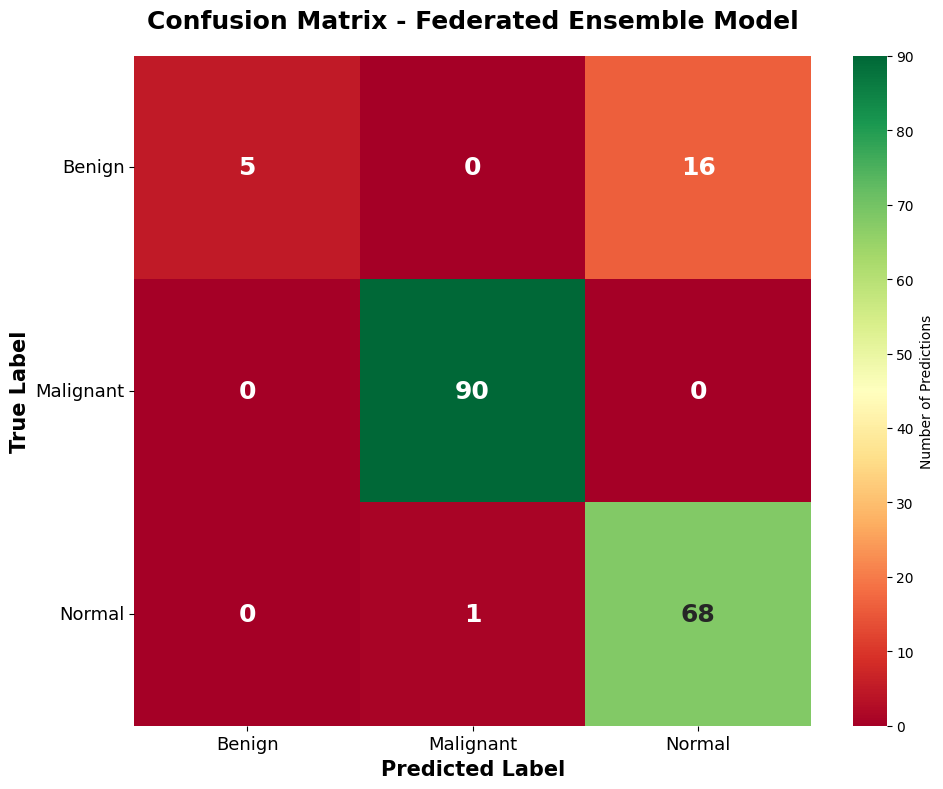


Confusion Matrix:
[[ 5  0 16]
 [ 0 90  0]
 [ 0  1 68]]

Total predictions: 180


In [18]:
# Plot confusion matrix for ensemble
cm = confusion_matrix(y_true_ensemble, y_pred_ensemble)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn',
            xticklabels=unique_labels, yticklabels=unique_labels,
            annot_kws={'fontsize': 18, 'fontweight': 'bold'},
            cbar_kws={'label': 'Number of Predictions'})
plt.title('Confusion Matrix - Federated Ensemble Model',
         fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=15, fontweight='bold')
plt.ylabel('True Label', fontsize=15, fontweight='bold')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13, rotation=0)
plt.tight_layout()
plt.savefig('/content/federated_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Print confusion matrix statistics
print("\nConfusion Matrix:")
print(cm)
print(f"\nTotal predictions: {cm.sum()}")

In [19]:
# Per-class detailed metrics
print("\n" + "="*70)
print("PER-CLASS METRICS (Binary Classification Perspective)")
print("="*70)

for class_idx, class_name in enumerate(unique_labels):
    # Binary classification: current class vs all others
    y_true_binary = (y_true_ensemble == class_idx).astype(int)
    y_pred_binary = (y_pred_ensemble == class_idx).astype(int)

    # Calculate confusion matrix elements
    tn = np.sum((y_true_binary == 0) & (y_pred_binary == 0))
    fp = np.sum((y_true_binary == 0) & (y_pred_binary == 1))
    fn = np.sum((y_true_binary == 1) & (y_pred_binary == 0))
    tp = np.sum((y_true_binary == 1) & (y_pred_binary == 1))

    # Calculate metrics
    accuracy_class = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision_class = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_class = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity_class = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1_class = 2 * (precision_class * recall_class) / (precision_class + recall_class) if (precision_class + recall_class) > 0 else 0

    print(f"\n{class_name.upper()}:")
    print(f"  True Positives:  {tp:4.0f}  |  True Negatives:  {tn:4.0f}")
    print(f"  False Positives: {fp:4.0f}  |  False Negatives: {fn:4.0f}")
    print(f"  " + "-" * 50)
    print(f"  Accuracy:    {accuracy_class:.5f}")
    print(f"  Precision:   {precision_class:.5f}")
    print(f"  Recall:      {recall_class:.5f}")
    print(f"  Specificity: {specificity_class:.5f}")
    print(f"  F1-Score:    {f1_class:.5f}")


PER-CLASS METRICS (Binary Classification Perspective)

BENIGN:
  True Positives:     5  |  True Negatives:   159
  False Positives:    0  |  False Negatives:   16
  --------------------------------------------------
  Accuracy:    0.91111
  Precision:   1.00000
  Recall:      0.23810
  Specificity: 1.00000
  F1-Score:    0.38462

MALIGNANT:
  True Positives:    90  |  True Negatives:    89
  False Positives:    1  |  False Negatives:    0
  --------------------------------------------------
  Accuracy:    0.99444
  Precision:   0.98901
  Recall:      1.00000
  Specificity: 0.98889
  F1-Score:    0.99448

NORMAL:
  True Positives:    68  |  True Negatives:    95
  False Positives:   16  |  False Negatives:    1
  --------------------------------------------------
  Accuracy:    0.90556
  Precision:   0.80952
  Recall:      0.98551
  Specificity: 0.85586
  F1-Score:    0.88889


## 9. Compare Individual Models vs Federated Ensemble

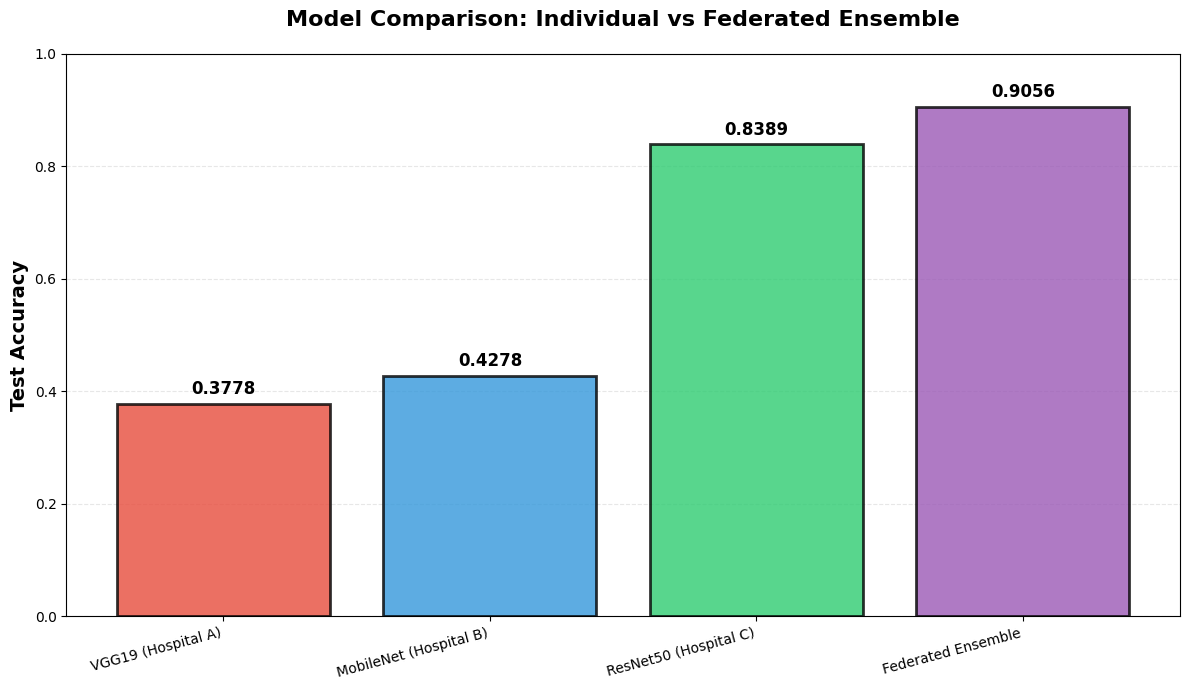


Federated Ensemble Improvement: +0.0667 (+6.67%)
Best Individual Model: 0.8389
Federated Ensemble:    0.9056


In [20]:
# Create comparison visualization
fig, ax = plt.subplots(figsize=(12, 7))

# Calculate accuracies for each model
accuracies = []
model_labels = []

for client_id in range(CONFIG['NUM_CLIENTS']):
    y_pred_client = client_predictions_list[client_id]
    acc = accuracy_score(y_true, y_pred_client[:len(y_true)])
    accuracies.append(acc)
    model_labels.append(client_names[client_id])

# Add ensemble
accuracies.append(ensemble_acc)
model_labels.append('Federated Ensemble')

# Create bar plot
colors_plot = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']
bars = ax.bar(model_labels, accuracies, color=colors_plot, alpha=0.8, edgecolor='black', linewidth=2)

# Customize plot
ax.set_ylabel('Test Accuracy', fontsize=14, fontweight='bold')
ax.set_title('Model Comparison: Individual vs Federated Ensemble',
            fontsize=16, fontweight='bold', pad=20)
ax.set_ylim([0, 1.0])
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
           f'{acc:.4f}',
           ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.savefig('/content/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print improvement
best_individual = max(accuracies[:-1])
improvement = ensemble_acc - best_individual
print(f"\n" + "="*70)
print(f"Federated Ensemble Improvement: {improvement:+.4f} ({improvement*100:+.2f}%)")
print(f"Best Individual Model: {best_individual:.4f}")
print(f"Federated Ensemble:    {ensemble_acc:.4f}")
print("="*70)

## 10. Save Models and Results

In [21]:
# Save all client models
print("\nSaving trained models...")

for client_id, model in enumerate(client_models):
    model_name = ['vgg19', 'mobilenet', 'resnet50'][client_id]
    save_path = f'/content/drive/MyDrive/FL_{model_name}_client_{client_id}.h5'
    model.save(save_path)
    print(f"✓ Saved {client_names[client_id]} to {save_path}")

# Save federated learning history
history_df = pd.DataFrame({
    'round': fl_history['rounds'],
    'vgg19_train_acc': fl_history['clients'][0]['train_acc'],
    'mobilenet_train_acc': fl_history['clients'][1]['train_acc'],
    'resnet50_train_acc': fl_history['clients'][2]['train_acc'],
    'ensemble_test_acc': fl_history['global_test_acc']
})
history_df.to_csv('/content/drive/MyDrive/federated_learning_history.csv', index=False)
print(f"\n✓ Saved training history to federated_learning_history.csv")

# Save final evaluation results
results = {
    'configuration': CONFIG,
    'ensemble_metrics': {
        'accuracy': float(ensemble_acc),
        'precision': float(ensemble_precision),
        'recall': float(ensemble_recall),
        'f1_score': float(ensemble_f1)
    },
    'confusion_matrix': cm.tolist(),
    'class_names': unique_labels
}

import json
with open('/content/drive/MyDrive/federated_results.json', 'w') as f:
    json.dump(results, f, indent=4)
print(f"✓ Saved evaluation results to federated_results.json")

print("\n" + "="*70)
print("ALL FILES SAVED SUCCESSFULLY TO GOOGLE DRIVE!")
print("="*70)


Saving trained models...


✓ Saved VGG19 (Hospital A) to /content/drive/MyDrive/FL_vgg19_client_0.h5


✓ Saved MobileNet (Hospital B) to /content/drive/MyDrive/FL_mobilenet_client_1.h5
✓ Saved ResNet50 (Hospital C) to /content/drive/MyDrive/FL_resnet50_client_2.h5

✓ Saved training history to federated_learning_history.csv
✓ Saved evaluation results to federated_results.json

ALL FILES SAVED SUCCESSFULLY TO GOOGLE DRIVE!
